## Libraries

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.constants as cs
import scipy 
from scipy import signal
from scipy.linalg import toeplitz
from cmath import phase
import matplotlib.colors as mcolors

## Inputs

In [4]:
# inputs
n_k = 201     #number of k points in BZ
n_max = 5  # max number of reciprocal lattice vectors
a= 5*10**(-10)  #lattice constant
g = 2.0*np.pi / a
k_values = np.linspace(-g/2,g/2,n_k)
M = cs.m_e      #mass
dim = 4096*8      # division in real space of the potential
x=np.linspace(-a/2,a/2,dim)  # x points of unit cell in real space 
V_max = 5.0
fill_fraction = 0.90
k_spring = 2.0


## Potentials

In [5]:
def square(x_arr, fill_f, V_maximum):
	dim_x = np.shape(x_arr)[0]
	V = np.zeros(dim_x)
	V[0:int(dim_x*fill_f)] = V_maximum
	return V

In [9]:
def harmonic(x_arr, k_spring):
	V = 0.5*k_spring*x_arr**2
	return V

In [134]:
def fft_V(V,n_max):
	"""Calculates the truncated real-valued Fast Fourier Transform (FFT) of a potential.

	Args:
	V (numpy.ndarray): The input signal to be transformed.
	n_max (int): The number of FFT coefficients to retain.

	Returns:
	numpy.ndarray: The truncated real-valued FFT of the input potential, 
				   with only the first 2*n_max coefficients preserved.
	"""
	V_fft = np.fft.rfft(V,norm='forward')
	V_fft[2*n_max+1:] = 0.0   
	return V_fft

def ifft_V(V_fft):
	"""
	Computes the inverse Fourier transform of a real-valued potential.

	Args:
	V_fft (numpy.ndarray): The input array containing the Fourier
							transform coefficients of the potential.

	Returns:
	numpy.ndarray: The reconstructed real-valued signal.
	"""
	V_recon = np.fft.irfft(V_fft,norm='forward')
	return V_recon

def V_GG(k,g,V_fft,n_max):
	"""Computes the coefficient matrix for the central equation.

	Args:
		k (float): The wavenumber in the Brillouin zone.
		g (float): The primitive reciprocal lattice vector.
		V_fft (array): The FFT of the potential.
		n_max (int): The maximum Fourier mode index.

	Returns:
		array: the central equation matrix.

	This function computes the coefficient matrix V_G for the central equation

	1. Computes the diagonal of the kinetic energy term using the formula
		`(hbar**2) * (k - n*g)**2 / (2*M*e)`, where `hbar` is the reduced Planck constant, 
		`M` is the electron mass, and `e` is the elementary charge.
	2. Constructs a Toeplitz matrix `V_G` from the first `2*n_max+1` elements of the 
		FFT of the potential and adds the diagonal kinetic energy term.

	This function assumes that the potential `V` is periodic with the periodicity of 
	the reciprocal lattice. The size of the FFT and the Toeplitz matrix are chosen 
	to be `2*n_max+1` to ensure accurate computation for all relevant k-points.

	Note that this function requires the following external libraries:

	- `numpy` for numerical operations and array manipulation.
	- `cs` (likely `constants`) for physical constants like `hbar`, `M`, and `e`.

	"""

	# compute the kinetic energy diagonal
	V_GG_diag = np.diag([(cs.hbar**2) * (k - n*g)**2/(2*M*cs.e) for n in np.arange(-n_max,n_max+1,1)])
	
	# compute the coeffiecient matrix and sum the kinetic diagonal
	V_GG = toeplitz(V_fft[0:2*n_max+1])
	V_GG = V_GG + V_GG_diag

	return V_GG

def compute_bands(g,V_fft,n_max,n_k):
	"""Computes bands (eigenvalues) and wavefunction coefficients (eigenvectors)
	   for a given periodic potential.

	Args:
		g (float): The magnitude of the reciprocal lattice vector.
		V_fft (np.ndarray): The Fourier transform of the 1D  potential.
		n_max (int): The maximum Fourier mode index.
		n_k (int): The number of k-points to sample in the Brillouin zone.

	Returns:
		tuple: A tuple containing two numpy arrays:
			k_bands (np.ndarray, shape=(n_k, 2*n_max+1)): The array of eigenvalues for each k-point.
			k_wave_fft (np.ndarray, shape=(n_k, 2*n_max+1, 2*n_max+1)): The array of eigenvectors for each k-point.
	"""

	# Initialize arrays to store bands (eigenvalues) and wavefunction coeffs (eigenvectors)
	k_bands = np.zeros((n_k,2*n_max+1),dtype=np.complex128)
	k_wave_fft = np.zeros((n_k,2*n_max+1,2*n_max+1),dtype=np.complex128)

	# Sampling k values in the Brillouin zone
	k_values = np.linspace(-g/2,g/2,n_k)

	# loop over k values solving the eigenproblem
	for i_k,k in enumerate(k_values):

		# compute the coeff matrix
		V_GG_k = V_GG(k,g,V_fft,n_max)

		# solve the eigenproblem
		k_bands[i_k],k_wave_fft[i_k] = np.linalg.eigh(V_GG_k,UPLO='U')

	return k_bands, k_wave_fft

def compute_wavefunction(g,x,k_values,k_wave_fft,i_k,i_band,n_max):

	# select k value
	k = k_values[i_k]

	# explicitly compute the wavefunction
	wavefunct = np.zeros(len(x), dtype=np.complex128)
	for i_c, c_k in zip(np.arange(-n_max,n_max+1,1),k_wave_fft[i_k,:,i_band]):
		wavefunct = wavefunct + c_k*np.exp(1j*(k+i_c*g)*x)

	return wavefunct


In [135]:
n_max=20
V = square(x,fill_fraction, offset,V_max)
# V = V_max*np.cos(g*x)
V_fft = fft_V(V,n_max)
V_recon = ifft_V(V_fft)
V_GG_k = V_GG(g,g,V_fft,n_max)
k_bands, k_wave_fft = compute_bands(g,V_fft,n_max,n_k)
wavefunct_val = compute_wavefunction(g,x,k_values,k_wave_fft,0,0,n_max)
wavefunct_cond = compute_wavefunction(g,x,k_values,k_wave_fft,0,1,n_max)

/home/giovi/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-1.0, 8.0)

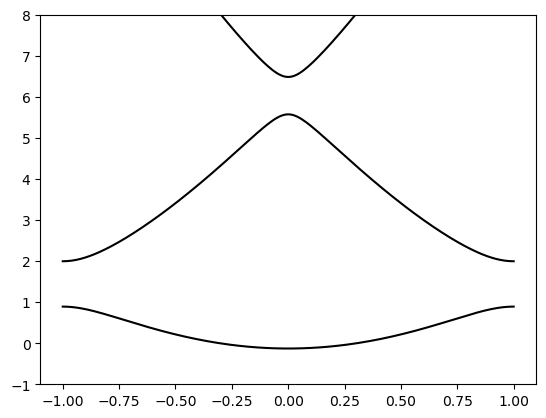

In [136]:
k_values = np.linspace(-g/2,g/2,n_k)
for n in np.arange(3):
    plt.plot(k_values/(g/2),k_bands[:,n]-V_fft[0],'k')
plt.ylim(-1,8)

In [137]:
k_bands[0,1]-k_bands[0,0]

(1.10430861352976+0j)

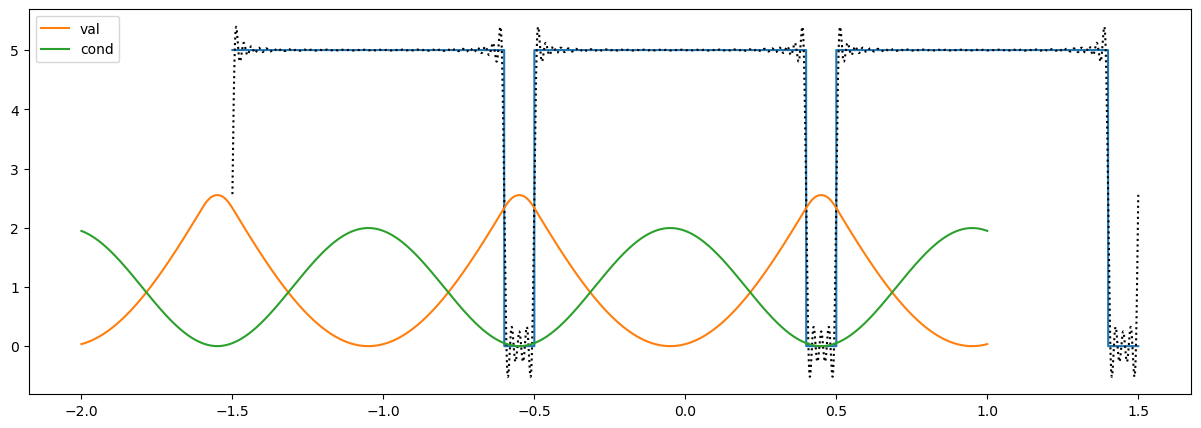

In [138]:
plt.figure(figsize=(15,5))
tile_x = np.concatenate((x-a,x,x+a))
tile_V = np.tile(V,3)
tile_V_recon = np.tile(V_recon,3)
tile_wavefunct_val = np.tile(wavefunct_val,3)
tile_wavefunct_cond = np.tile(wavefunct_cond,3)
plt.plot(tile_x/a,tile_V)
plt.plot(tile_x/a,tile_V_recon,'k:')
plt.plot(tile_x/a-1/2,np.abs(tile_wavefunct_val)**2,label='val')
plt.plot(tile_x/a-1/2,np.abs(tile_wavefunct_cond)**2,label='cond')
plt.legend()